## This code shows how to analyze a State Space Differential equation

In [14]:
import numpy as np
import rhodium 
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np
from rhodium import *
import networkx as nx



def dgl_1(
        m: float = 0.4, #Inertia
        d: float = 0.25, #Damping
        b: float = 50 #Susceptance
        )->float:
    #define the State Space matrizes
    A = [[0, 1],
        [-(1/m)*b, -(1/m)*d]]
    B = [[0],
        [1]]
    C = [[0, 1]]
    
    #define the State Space through scipy
    sys = sig.StateSpace(A, B, C, 0)
    
    #Simulation Parameters
    x0 = [0,0]
    start = 0
    stop = 30
    step = 0.001
    t = np.arange(start,stop,step)
    
    # Step Response
    t, y = sig.step(sys, x0, t)
    # Plotting
    #plt.plot(t, y)
    #plt.title("Step Response")
    #plt.xlabel("t")
    #plt.ylabel("y")
    #plt.grid()
    #plt.show()
    
    yPeak = np.max(y)
    
    return yPeak

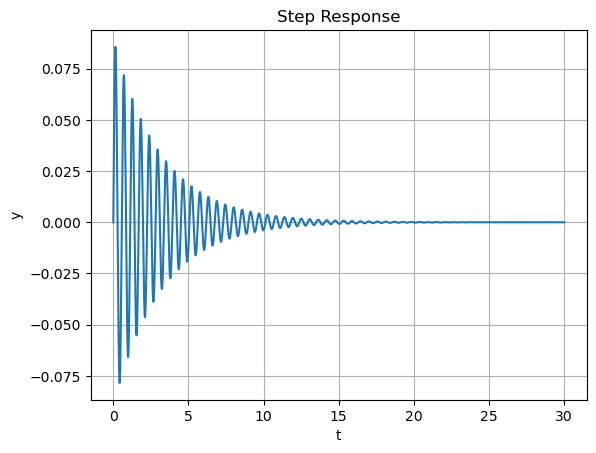

0.08566614093606618

In [5]:
dgl_1()

## Now we define the model!

In [9]:
## Now we define the model!
def return_model()-> Model:
    model = Model(dgl_1)
    
    model.parameters = [
        Parameter("m"),
        Parameter("d"),
        Parameter("b")]
    
    model.responses = [
        Response("yPeak", Response.MINIMIZE)]
    
    #model.constraints = [Constraint("reliability >= 0.95")]
    
    model.uncertainties = [UniformUncertainty("m", 0.001, 0.45),
                       UniformUncertainty("d", 0.0001, 0.8)]
    
    model.levers = [RealLever("b", 0.1, 100)]
    
    return model


In [11]:
model = return_model();
policies = optimize(model, "NSGAII", 1000)
# Print the optimized policies
for policy in policies:
    print(policy)
    

sa_results = sa(model, "yPeak", method="fast", nsamples=1000)
#print(opt_results)
print(sa_results)

OrderedDict([('b', 99.9999937377833), ('yPeak', 0.06133571325081561)])
First order sensitivity indices (confidence interval):
    m: +0.971450 (+0.029078)
    d: +0.018403 (+0.031745)
Total order sensitivity indices (confidence interval):
    m: +0.981149 (+0.061445)
    d: +0.018630 (+0.059030)


In [16]:
nodes = [1, 2, 3, 4, 5, 6]
edges = [[1, 2], [1, 3], [1, 5], [2, 3], [2, 4], [3, 4], [3, 5], [4, 6], [5, 6]]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

incidence_matrix = -nx.incidence_matrix(G, oriented=True) 
# ^ this returns a scipy sparse matrix, can convert into the full array as below
# (as long as your node count is reasonable: this'll have that squared elements)
print(incidence_matrix.toarray())

[[ 1.  1.  1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  1.  1.  0.  0.  0.  0.]
 [ 0. -1.  0. -1.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  0. -1. -1.  0.  1.  0.]
 [ 0.  0. -1.  0.  0.  0. -1.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0. -1. -1.]]


# *Now a representation on a more advanced level:*

C:\Users\santosch\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


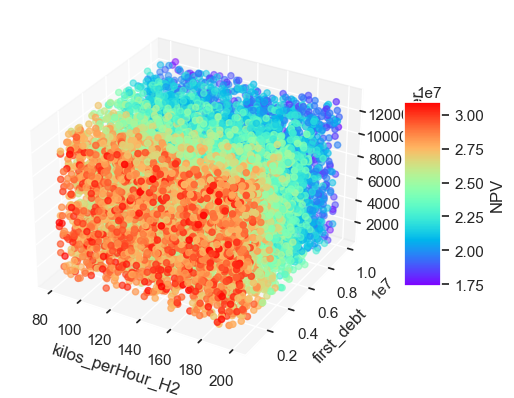

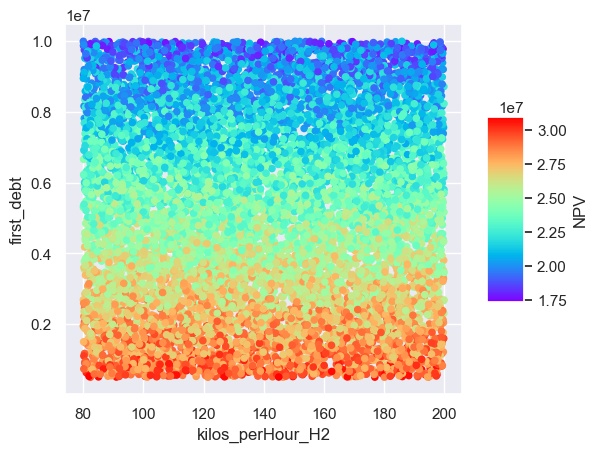

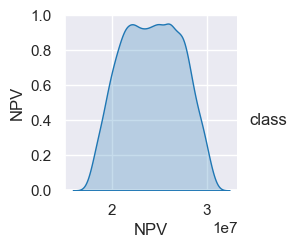

In [188]:
import numpy as np
import rhodium 
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np
from rhodium import *
import networkx as nx
import numpy_financial as npf

def my_input(
    input_1:float = 0
            )-> float: 
    return input_1

def electricity_expenses_1(
    elec_prices: float = 0.27, #[EURO/KWh]
    electrolyser_power: float = 10e3, #[KWh/ano]
    electricity_efficiency: float = 0.95 #[%]
                        )-> float: 
    electricity_expenses_yearly = (electrolyser_power*elec_prices)/(electricity_efficiency)
    return electricity_expenses_yearly # [EURO/ano] 


def annual_debt_1(
    first_debt = 1e6, #[EURO]
    rate_debt = 0.05 #[%]
                )->float:
    n = 10 #ten years of project
    annuity = first_debt*(rate_debt*((1+rate_debt))**(n))/(((1+rate_debt))**(n) -1)
    return annuity # [EURO/ano] 

def maintenance_costs_1(
    maintenance_cost_yearly = 20e3, #[EURO/ano]
    rate = 0.05 # [%]
                        )->float: 
    maintenance_rated = np.zeros(10)
    for n in range(0,10):
        maintenance_rated[n] = maintenance_cost_yearly*((1+rate))**n
        
    return maintenance_rated #Vector with maintenance costs 10 elements
    
    
def income_hydrogen(
    kilos_perHour_H2:float = 100, #[kg/h]
    cost_H2:float = 4.5, #[EURO/kg]
    hours_generating_yearly: float = 8000 #[h/ano]
                    )->float: 
    income_hydrogen_yearly=kilos_perHour_H2*cost_H2*hours_generating_yearly
    return income_hydrogen_yearly

def income_O2_waste(
    kilos_perHour_O2:float = 700, #[kg/h]
    cost_O2:float = 0.002, #[EURO/kg]
    hours_generating_yearly: float = 8000 #[h/ano]
                    )->float: 
    income_O2_yearly = kilos_perHour_O2*cost_O2*hours_generating_yearly
    return income_O2_yearly

def calculate_cash_flow_per_year(
    year: int = 0
                    )->float:
    maintenance_costs = maintenance_costs_1() 
    
    income = income_hydrogen()+income_O2_waste()
    expenses = electricity_expenses_1()+annual_debt_1()+maintenance_costs[year]

    CF = income-expenses
    return CF
    
def NPV(
    elec_prices: float = 0.27, #[EURO/KWh]
    electrolyser_power: float = 10e3, #[KWh/ano]
    electricity_efficiency: float = 0.95, #[%]
    first_debt = 1e6, #[EURO]
    rate_debt = 0.05, #[%]
    maintenance_cost_yearly = 20e3, #[EURO/ano]
    kilos_perHour_H2:float = 100, #[kg/h]
    cost_H2:float = 4.5, #[EURO/kg]
    hours_generating_yearly: float = 8000, #[h/ano]
    kilos_perHour_O2:float = 700, #[kg/h]
    cost_O2:float = 0.002, #[EURO/kg]
                 )->float:
    
    C_elec = electricity_expenses_1(elec_prices,
                                   electrolyser_power,
                                   electricity_efficiency)
    
    Annu = annual_debt_1(first_debt,
                        rate_debt)
    
    Wartung = maintenance_costs_1(maintenance_cost_yearly,
                                 rate_debt)

    gewinnH2 = income_hydrogen(kilos_perHour_H2 = 100,
                              cost_H2 = 4.5,
                              hours_generating_yearly = 8000)
    
    gewinnO2 = income_O2_waste(
                    kilos_perHour_O2 = 700, #[kg/h]
                    cost_O2 = 0.002,#[EURO/kg]
                    hours_generating_yearly = 8000 #[h/ano]
                    )

    CF = np.zeros(10)
    
    for n in range(0,10):
        income = gewinnH2+gewinnO2
        expenses = C_elec+Annu+Wartung[n]
        CF[n] = income-expenses

    NPV = npf.npv(rate_debt,CF)
    
    return NPV
    
    

def model()->Model: 
    model = Model(NPV)
    model.parameters = [
        Parameter("elec_prices"),
        Parameter("electrolyser_power"),
        Parameter("electricity_efficiency"),
        Parameter("first_debt"),
        Parameter("rate_debt"),
        Parameter("maintenance_cost_yearly"),
        Parameter("kilos_perHour_H2"),
        Parameter("cost_H2"),
        Parameter("hours_generating_yearly"),
        Parameter("kilos_perHour_O2"),
        Parameter("cost_O2"),
    ]

    model.responses = [
        Response("NPV", Response.MAXIMIZE)]

    model.levers = [RealLever("hours_generating_yearly", 8000, 8500, length=100)]

    # For uncertainties, some are expanded ranges around values found in the literature, and some are assumed. Refer to full article.
    model.uncertainties = [
        UniformUncertainty("elec_prices", 0.27, 0.36), 
        UniformUncertainty("electrolyser_power", 1e3, 13e3),
        UniformUncertainty("electricity_efficiency", 0.90, 0.97), 
        UniformUncertainty("first_debt",0.5e6,10e6), 
        UniformUncertainty("rate_debt",0.03,0.06),
        UniformUncertainty("maintenance_cost_yearly",15e3, 25e3), 
        UniformUncertainty("kilos_perHour_H2",80,200),
        UniformUncertainty("cost_H2", 3.5, 7.5), 
        UniformUncertainty("kilos_perHour_O2", 400, 800),
        UniformUncertainty("cost_O2", 0.001, 0.003), 
        ]
    return model
model = model()
output = cache("NPV", lambda: optimize(model, "NSGAII", 10000))
#output

SOWs = sample_lhs(model, 10000)
SOWs

policy = {}
#policy = {"hours_generating_yearly": 8200}
inputs = update(SOWs, policy)
model_results = evaluate(model, inputs)
model_results


scatter3d(model, model_results, x="kilos_perHour_H2", y="first_debt", z = "electrolyser_power", c="NPV")
#fig.savefig("3_Sobol_Us1.png", dpi=600)
scatter2d(model, model_results, x="kilos_perHour_H2", y="first_debt", c="NPV")
#joint(model, model_results, x="kilos_perHour_H2", y="electrolyser_power", color="turquoise")
pairs(model, model_results, brush=["NPV > 0"])
#model_results


#optim

In [ ]:
A = np.zeros(3)
A